## Table of Contents

[Part 1 - Student details](#part-1---student-details)

[Part 2 - Experiments](#part-2---experiments)

- [Visualization](#visualization)

- [Feature engineering](#feature-engineering)

- [Check for missing Data](#check-for-missing-data---and-fill-when-needed)

- [Find Outliers](#find-outliers)

[Part 3 - Training flow](#part-3---training-flow)

- [KNN training](#knn-training)

- [Naive Bayes training](#naive-bayes-training)

[Part 4 - Apply on test and show model performance estimation](#part-4---apply-on-test-and-show-model-performance-estimation)

- [KNN algorithm testing](#knn-algorithm-testing)

- [Naive Bayes algorithm testing](#naive-bayes-algorithm-testing)

### Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 7938</pre>

In [1]:
# student 1: Israel 7938
# student 2: Eran 6215
# student 3: Avihai 2474
# student 4: Almog 8269
# student 5: Liron 5068
# student 6: Matan 9999

## Part 2 - Experiments
You could add as many code cells as needed

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, KFold

In [3]:
train_set = pd.read_csv('titanic_train.csv')
test_set = pd.read_csv("titanic_test.csv")

In [4]:
train_set.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [5]:
test_set.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


In [6]:
def showSurvivorsByGenderAndChildren():
    survivors = train_set[train_set['Survived'] == 1]

    #Men
    survived_man = survivors[(survivors['Sex'] == 1) & (survivors['Age'] > 18)]
    survived_man_count = len(survived_man)

    #Women
    survived_women = survivors[(survivors['Sex'] == 0) & (survivors['Age'] > 18)]
    survived_women_count = len(survived_women)

    #Kids
    survived_kids = survivors[survivors['Age'] <= 18]
    survived_kids_count = len(survived_kids)

    survived_count = len(survivors)

    return [survived_man_count, survived_women_count, survived_kids_count, survived_count]

In [7]:
display(train_set.isnull().sum())
print("No missing values in train set")

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64

No missing values in train set


[Go to the beginning of the assignment](#table-of-contents)

## Visualization

In [8]:
# Creating a dataframe for the pie plot using the given parameters
def create_pie_table(population):
    data = {'Category': ['Male', 'Female', 'Kids', 'Total'],
            'Survived': population}

    survivors_df = pd.DataFrame(data)
    survived_count = population[-1]  #get last item

    survivors_df['Percentage'] = survivors_df['Survived'].apply(lambda x: round((x / survived_count) * 100, 1))
    return survivors_df


def show_pie_survived(population_counts):
    labels = ['Male', 'Female', 'Kids']
    colors = ['#E91694', '#94E916', '#1694E9']
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.pie(population_counts, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 20})
    plt.title('Survivors of the Titanic', fontsize=20)
    fig.patch.set_facecolor('white')
    plt.show()

,Category,Survived,Percentage
0,Male,69,24.6
1,Female,156,55.5
2,Kids,56,19.9
3,Total,281,100.0


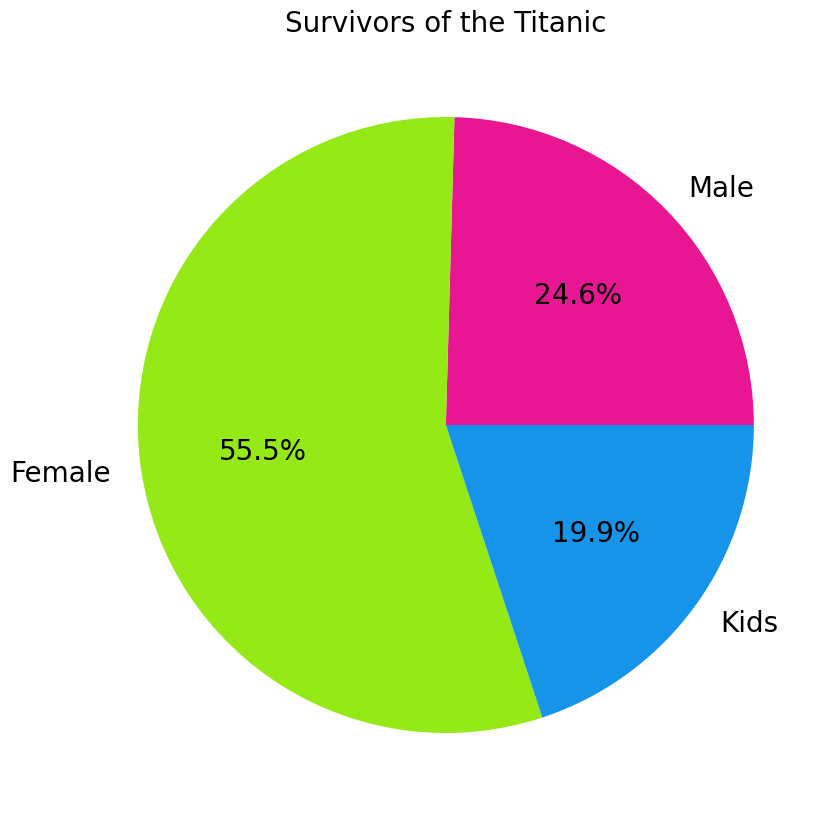

In [9]:
population = showSurvivorsByGenderAndChildren()

# Creating a data table for the pie plot
survived_percentage_df = create_pie_table(population)
display(survived_percentage_df)

population.pop()  #remove last item - total count
show_pie_survived(population)

In [10]:
def plot_hist_gender_survivors():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    genders = {'Female': 0, 'Male': 1}
    colors = {'survived': ["#76FF00", "#FF5100"], 'not_survived': ["#8900FF", "#00AEFF"]}

    #loop through the combinations of gender and survived status
    for ax, (title, sex) in zip(axes, genders.items()):
        for status, color in colors.items():
            ages = train_set[(train_set['Sex'] == sex) & (train_set['Survived'] == (status == 'survived'))].Age
            sns.histplot(ages, bins=10, label=status, ax=ax, kde=False, color=color[sex])

        ax.legend()
        ax.set_title(title)

    plt.show()

In [11]:
# Making DataFrame for the histogram above with age group
def createHistTableAG(data_frame):
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
    age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

    data_frame = data_frame.copy()
    data_frame['AgeGroup'] = pd.cut(data_frame['Age'], bins=age_bins, labels=age_labels, right=False)

    data = {
        'AgeGroup': age_labels,
        'Survived Women': [],
        'Not Survived Women': [],
        'Survived Men': [],
        'Not Survived Men': []
    }

    for age_group in age_labels:
        survived_women = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 0) & (
                data_frame['Survived'] == 1)])
        not_survived_women = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 0) & (
                data_frame['Survived'] == 0)])
        survived_men = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 1) & (
                data_frame['Survived'] == 1)])
        not_survived_men = len(data_frame[(data_frame['AgeGroup'] == age_group) & (data_frame['Sex'] == 1) & (
                data_frame['Survived'] == 0)])

        data['Survived Women'].append(survived_women)
        data['Not Survived Women'].append(not_survived_women)
        data['Survived Men'].append(survived_men)
        data['Not Survived Men'].append(not_survived_men)

    survivors_by_age = pd.DataFrame(data)

    return survivors_by_age

,AgeGroup,Survived Women,Not Survived Women,Survived Men,Not Survived Men
0,0-10,16,9,15,12
1,11-20,28,8,5,44
2,21-30,75,28,33,180
3,31-40,44,7,19,59
4,41-50,18,9,9,35
5,51-60,9,2,4,23
6,61-70,3,0,2,10
7,71-80,0,0,0,5


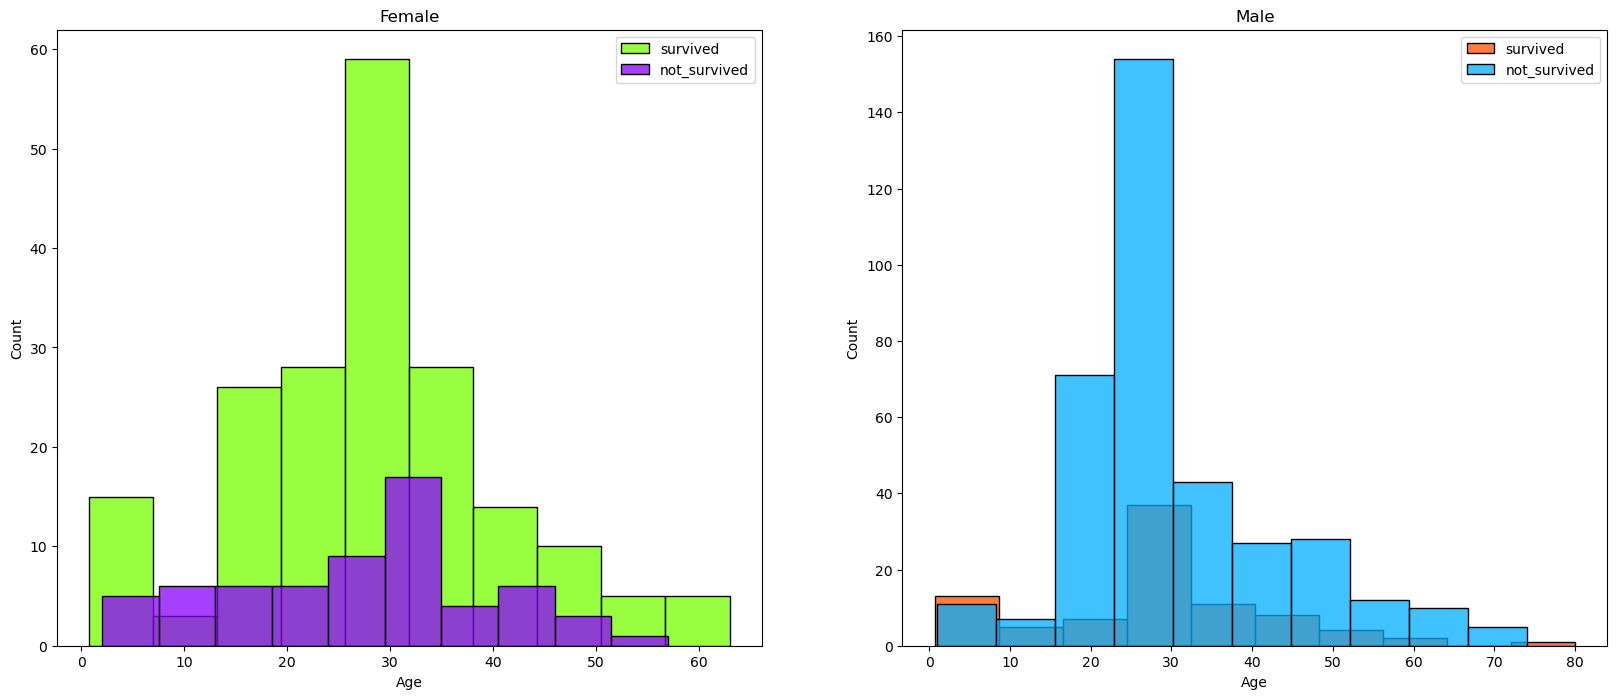

In [12]:
#Creating a data table for the histogram with age group
histTableAges = createHistTableAG(train_set)
display(histTableAges)

plot_hist_gender_survivors()

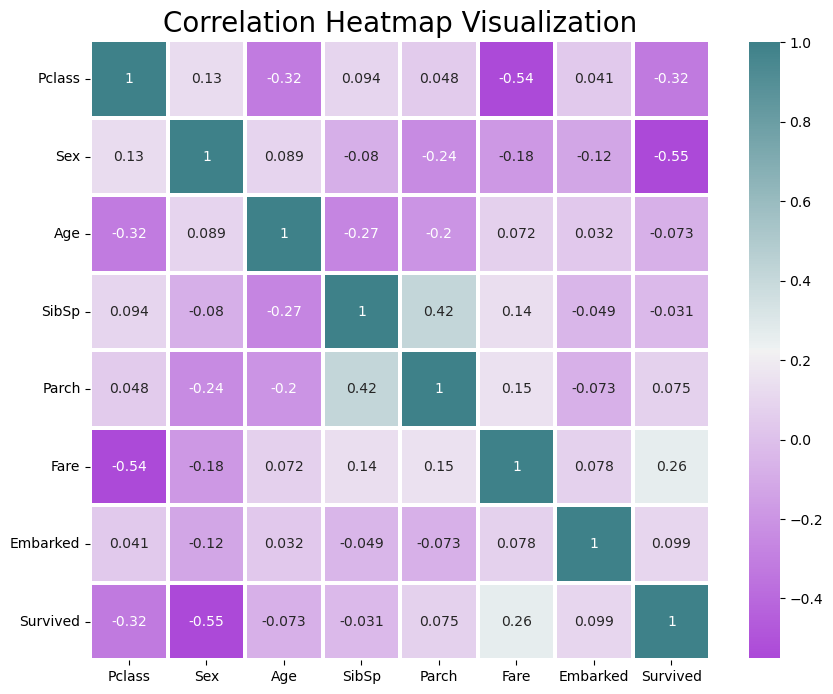

In [13]:
# Create a figure with a specific size
plt.figure(figsize=(10, 10))

# Calculate the correlation matrix
corr = train_set.corr()

# Define a custom diverging color palette
cmap = sns.diverging_palette(290, 205, as_cmap=True)

# Create a heatmap of the correlation matrix
sns.heatmap(corr,
            cmap=cmap,       # Use the custom color palette
            annot=True,      # Annotate cells with correlation coefficients
            square=True,     # Force the cells to be square-shaped
            linewidths=1.5,  # Set the width of the lines between cells
            cbar_kws={"shrink": .8})  # Shrink the color bar to fit better

# Set the title of the heatmap
plt.title('Correlation Heatmap Visualization', fontsize=20)

# Rotate y-axis tick labels to be horizontal
plt.yticks(rotation=0)

# Display the plot
plt.show()

[Go to the beginning of the assignment](#table-of-contents)

## Extract x_train/test and y_train/test

In [14]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
label = 'Survived'
x_train = train_set[features]
y_train = train_set[label]

x_test = test_set[features]
y_test = test_set[label]

# Feature engineering

### Find Outliers

#### let's check for Age outliers (using boxplot)

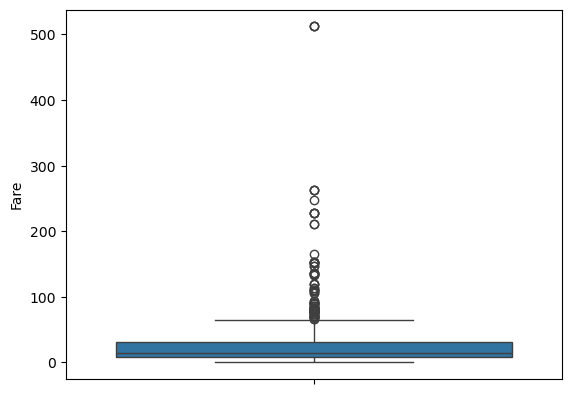

In [15]:
# Fare outliers
sns.boxplot(train_set.Fare)
plt.show() #discards <Axes: ylabel='Fare'>

In [16]:
train_set["Fare"].median()

14.5

In [17]:
train_set["Fare"].describe()

count    712.000000
mean      32.379429
std       49.836074
min        0.000000
25%        7.925000
50%       14.500000
75%       31.275000
max      512.329200
Name: Fare, dtype: float64

In [18]:
# Find Fare outliers:

# "minimum" = Q1 - 1.5 * IQR
# "maximum" = Q3 + 1.5 * IQR
def outliersByIQR(col_name):
    Q1 = np.percentile(train_set[col_name], 25)
    Q3 = np.percentile(train_set[col_name], 75)
    IQR = Q3 - Q1

    Fare_Outliers = train_set[(train_set[col_name] < Q1 - 1.5 * IQR) | (train_set[col_name] > Q3 + 1.5 * IQR)].index
    print(f'Sum of Age_outliers: {len(Fare_Outliers)}')

# remove outliers by column name
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

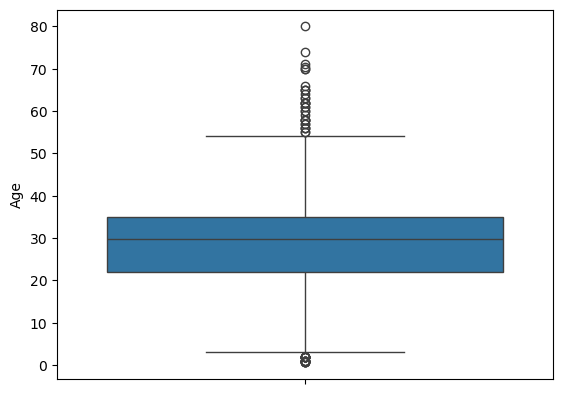

In [19]:
# check outliers for Age
sns.boxplot(train_set.Age)
plt.show() 

In [20]:
train_set["Age"].median()
train_set["Age"].describe()

count    712.000000
mean      29.531213
std       13.188028
min        0.670000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [21]:
train_set["Fare"].median()
train_set["Fare"].describe()

count    712.000000
mean      32.379429
std       49.836074
min        0.000000
25%        7.925000
50%       14.500000
75%       31.275000
max      512.329200
Name: Fare, dtype: float64

In [22]:
# Find Age outliers:
outliersByIQR("Age")
outliersByIQR("Fare")

Sum of Age_outliers: 54
Sum of Age_outliers: 93


In [23]:
#save the dataframe with the removed data
updated_df = remove_outlier(train_set, "Age")
print(updated_df.count())

Pclass      658
Sex         658
Age         658
SibSp       658
Parch       658
Fare        658
Embarked    658
Survived    658
dtype: int64


In [24]:
#save the dataframe with the removed data
train_set = remove_outlier(train_set, "Fare")
print(train_set.count())

Pclass      619
Sex         619
Age         619
SibSp       619
Parch       619
Fare        619
Embarked    619
Survived    619
dtype: int64


[Go to the beginning of the assignment](#table-of-contents)

### Check for missing Data - and fill when needed

In [25]:
# Let's start by finding the missing values
def check_missing_data(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]  # Only show columns with missing data
    return missing_data

def fix_missing_values(data_frame):
    fill_strategies = {
        'Pclass': data_frame['Pclass'].mode()[0],
        'Sex': data_frame['Sex'].mode()[0],
        'Age': data_frame['Age'].mean(),
        'SibSp': data_frame['SibSp'].mode()[0],
        'Parch': data_frame['Parch'].mode()[0],
        'Fare': data_frame['Fare'].median(),
        'Embarked': data_frame['Embarked'].mode()[0],
        'Survived': data_frame['Survived'].mode()[0]
    }

    for column, fill_value in fill_strategies.items():
        if column in data_frame.columns:
            data_frame[column].fillna(fill_value, inplace=True)

    return data_frame

In [26]:
missing_data = check_missing_data(train_set)
# print("Missing data",missing_data)

if len(missing_data) > 0:
    fix_missing_values(train_set)
    # check_missing_data(train_set)
    print(f"Filled missing data ({missing_data})")
else:
    print("No missing data")

No missing data


In [27]:
# Use the NumPy percentile() method to find the percentiles
def agePercentile(dataFrame):
    x_age = np.percentile(dataFrame["Age"], 75)
    y_age = np.percentile(dataFrame["Age"], 90)

    print(f'x_age meaning that 75% of the people on the Titanic are {x_age} years old')
    print(f'y_age meaning that 90% of the people on the Titanic are {y_age} years old')

In [28]:
agePercentile(train_set)

x_age meaning that 75% of the people on the Titanic are 34.0 years old
y_age meaning that 90% of the people on the Titanic are 46.200000000000045 years old


[Go to the beginning of the assignment](#table-of-contents)

#### Feature engineering for Naive Bayes:

##### Basic train ,test function for naive bayes

In [29]:
def train_naive_bayes(x_train, y_train):
    # Initialize the Gaussian Naive Bayes model
    model = GaussianNB()

    # Fit the model to the training data
    model.fit(x_train, y_train)

    return model

def test_naive_bayes(model: GaussianNB, X_test, y_test):
    # Predict the target values for the test set
    y_pred = model.predict(X_test) # Predicting the model

    # Calculate the accuracy of the model

    accuracy = accuracy_score(y_test, y_pred)

     # Generate a classification report
    report = classification_report(y_test, y_pred) # Evaluating the performance of the model

    return accuracy, report

##### Feature engineering checks

In [30]:
def get_best_feature_engineering_techniques(X_train, X_test, y_train, y_test, max_pca_dim=5):
    """
    Evaluate different feature engineering techniques and determine the best one based on accuracy.

    Parameters:
    X_train (numpy.ndarray): Training feature set.
    X_test (numpy.ndarray): Testing feature set.
    y_train (numpy.ndarray): Training labels.
    y_test (numpy.ndarray): Testing labels.
    max_pca_dim (int, optional): Maximum number of dimensions for PCA. Default is 5.

    Returns:
    tuple: A tuple containing:
        - best_accuracy (float): The highest accuracy achieved.
        - best_technique (str): The name of the best feature engineering technique.
        - best_X_train (numpy.ndarray): The transformed training feature set corresponding to the best technique.
        - best_X_test (numpy.ndarray): The transformed testing feature set corresponding to the best technique.
    """
    techniques = [] # Initializing a list to save techniques of feature engineering
    best_accuracy = 0
    best_technique = '' # A string to keep the best technique used for feature engineering
    best_X_train = X_train # Copying a new dataframe to save the dataframe with the best feature engineering
    best_X_test = X_test

    # No scaling or PCA (baseline)
    techniques.append(('No Feature Engineering', X_train, X_test)) # Adding techniques to the list

    # PCA only
    for dim in range(1, max_pca_dim + 1): # Checking in a loop each one of dimensions we lowered in PCA
        pca = PCA(n_components=dim) # Performing PCA with the dimensions from 1 dimension to max dimension (determined by size of columns in dataset)
        X_train_pca = pca.fit_transform(X_train) # Training and applying the learned transformation to new data
        X_test_pca = pca.transform(X_test) # Applying the learned transformation to new data
        techniques.append((f'PCA with {dim} dimensions', X_train_pca, X_test_pca)) # Adding techniques to the list
        
    # Scaling only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # Training and applying the learned transformation to new data
    X_test_scaled = scaler.transform(X_test) # Applying the learned transformation to new data
    techniques.append(('Scaling Only', X_train_scaled, X_test_scaled)) # Adding techniques to the list


    # Scaling with PCA
    for dim in range(1, max_pca_dim + 1): # Checking in a loop each one of dimensions we lowered in PCA
        pca = PCA(n_components=dim) # Performing PCA with the dimensions from 1 dimension to max dimension (determined by size of columns in dataset)
        X_train_pca = pca.fit_transform(X_train_scaled) # Training and applying the learned transformation to new data
        X_test_pca = pca.transform(X_test_scaled) # Applying the learned transformation to new data
        techniques.append((f'Scaling + PCA with {dim} dimensions', X_train_pca, X_test_pca)) # Adding techniques to the list

    results = []
    
    # Perform 5-fold cross-validation with grid search
    for name, X_train_transformed, X_test_transformed in techniques:
        model = GaussianNB()  # Saving the model as a variable for later use

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(estimator=model, param_grid={}, cv=5, scoring='accuracy') # Using grid-search with 5 fold 
        grid_search.fit(X_train_transformed, y_train) # Learn and estimate the parameters of the transformation in datasets

        # Get the best model from grid search
        best_model = grid_search.best_estimator_

        # Evaluate on test set
        accuracy = best_model.score(X_test_transformed, y_test)
        results.append((name, accuracy))

        # Check if this technique gives better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy # Updating maximum accuracy
            best_technique = name # Updating best techinque of feature engineering used
            best_X_train = X_train_transformed # Updating datasets with best feature engineering method
            best_X_test = X_test_transformed # Updating datasets with best feature engineering method
    accuracy_df = pd.DataFrame(results, columns=['Technique', 'Accuracy'])
    return best_accuracy, best_technique, best_X_train, best_X_test,accuracy_df # Returning the best accuracy, technique and datasets

In [31]:
max_accuracy, best_technique, best_X_train, best_X_test,acc_df = get_best_feature_engineering_techniques(x_train, x_test, y_train, y_test, max_pca_dim=5)
print(f'Max Accuracy: {max_accuracy}')
print(f'Best Feature Engineering Technique: {best_technique}')
display(acc_df)

Max Accuracy: 0.8156424581005587
Best Feature Engineering Technique: Scaling + PCA with 3 dimensions


,Technique,Accuracy
0,No Feature Engineering,0.810056
1,PCA with 1 dimensions,0.698324
2,PCA with 2 dimensions,0.698324
3,PCA with 3 dimensions,0.715084
4,PCA with 4 dimensions,0.726257
5,PCA with 5 dimensions,0.720670
6,Scaling Only,0.810056
7,Scaling + PCA with 1 dimensions,0.698324
8,Scaling + PCA with 2 dimensions,0.748603
9,Scaling + PCA with 3 dimensions,0.815642


[Go to the beginning of the assignment](#table-of-contents)

In [32]:
def scaling(x_train,x_test):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled,x_test_scaled

## KNN training:

In [33]:
def KNN_Train(x_train,y_train,x_test, neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(x_train, y_train)
    return knn.predict(x_test)

In [34]:
def KNN_Test(x_train, y_train,x_test, y_test, n):
    y_pred = KNN_Train(x_train,y_train, x_test,n)
    accuracy = accuracy_score(y_test, y_pred)
    class_report_knn = classification_report(y_test, y_pred)
    return accuracy, class_report_knn

In [35]:
def plot_knn_test(neighbors, accuracy_scores):
    plt.figure(figsize=(15, 10))
    plt.plot(neighbors, accuracy_scores)
    plt.xlabel('Number of Neighbors', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.title('Accuracy vs. Number of Neighbors', fontsize=20)

    # Finding the maximum accuracy and its corresponding neighbor
    max_index = np.argmax(accuracy_scores)
    max_neighbor = neighbors[max_index]
    max_accuracy = accuracy_scores[max_index]

    # Adding annotation
    plt.annotate(f'Max Accuracy: {max_accuracy:.2f} ({max_neighbor} neighbors)',
                 xy=(max_neighbor, max_accuracy),  # Arrowhead position
                 xytext=(max_neighbor - 10, max_accuracy),  # Text position above the point
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 ha='right', fontsize=14, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    plt.show()

In [36]:
def get_optimal_neighbors(x_train, y_train, x_test, y_test):
    accuracy_scores = []
    for n in range(1,50):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
    max_result = max(accuracy_scores)
    return max_result, accuracy_scores

In [53]:
def compare_feature_engineering_KNN(x_train_old, y_train_old, x_test_old, y_test_old, param_grid, numerical_features):
    techniques = []
    results = []

    # Copy the datasets to avoid modifying the originals
    x_train = x_train_old.copy()
    y_train = y_train_old.copy()
    x_test = x_test_old.copy()
    y_test = y_test_old.copy()

    # Handle NaN values in the target variable
    y_train = y_train.dropna()
    y_test = y_test.dropna()
    x_train = x_train.loc[y_train.index]
    x_test = x_test.loc[y_test.index]

    # No Feature Engineering
    neighbors = np.arange(1, 50)
    accuracy, _ = KNN_Test(x_train, y_train, x_test, y_test, 5)
    techniques.append(('No Feature Engineering', x_train, x_test))
    results.append(('No Feature Engineering', accuracy))
    max_result, accuracy_scores = get_optimal_neighbors(x_train, y_train, x_test, y_test)
    techniques.append((f'Max Accuracy with Optimal Number of Neighbors: {max_result}', x_train, x_test))
    results.append((f'Max Accuracy with Optimal Number of Neighbors: {max_result}', max_result))
    plot_knn_test(neighbors, accuracy_scores)

    # Scaling Only
    x_train_scaled, x_test_scaled = scaling(x_train, x_test)
    accuracy, _ = KNN_Test(x_train_scaled, y_train, x_test_scaled, y_test, 5)
    results.append(("Scaling Only", accuracy))
    techniques.append(('Scaling Only', x_train_scaled, x_test_scaled))
    max_result, accuracy_scores = get_optimal_neighbors(x_train_scaled, y_train, x_test_scaled, y_test)
    results.append((f'Scaling with Max Accuracy with Optimal Number of Neighbors: {max_result}', max_result))
    techniques.append((f'Scaling with Max Accuracy with Optimal Number of Neighbors: {max_result}', x_train_scaled, x_test_scaled))
    plot_knn_test(neighbors, accuracy_scores)

    # Grid Search
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    best_model_grid = KNeighborsClassifier(**best_params)
    best_model_grid.fit(x_train, y_train)
    y_pred_grid = best_model_grid.predict(x_test)
    accuracy_grid = accuracy_score(y_test, y_pred_grid)
    results.append(('Grid Search', accuracy_grid))

    # Polynomial Features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    x_train_poly = poly.fit_transform(x_train[numerical_features])
    x_test_poly = poly.transform(x_test[numerical_features])
    
    # Combine polynomial features with non-numerical features
    x_train_poly = np.hstack([x_train.drop(columns=numerical_features).values, x_train_poly])
    x_test_poly = np.hstack([x_test.drop(columns=numerical_features).values, x_test_poly])
    
    # Grid Search with Polynomial Features
    grid_search_poly = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search_poly.fit(x_train_poly, y_train)
    best_params_poly = grid_search_poly.best_params_
    best_model_poly = KNeighborsClassifier(**best_params_poly)
    best_model_poly.fit(x_train_poly, y_train)
    y_pred_poly = best_model_poly.predict(x_test_poly)
    accuracy_poly = accuracy_score(y_test, y_pred_poly)
    
    results.append(('Polynomial Features with Grid Search', accuracy_poly))

    # Create DataFrame
    df_results = pd.DataFrame(results, columns=['Technique', 'Accuracy'])

    return df_results


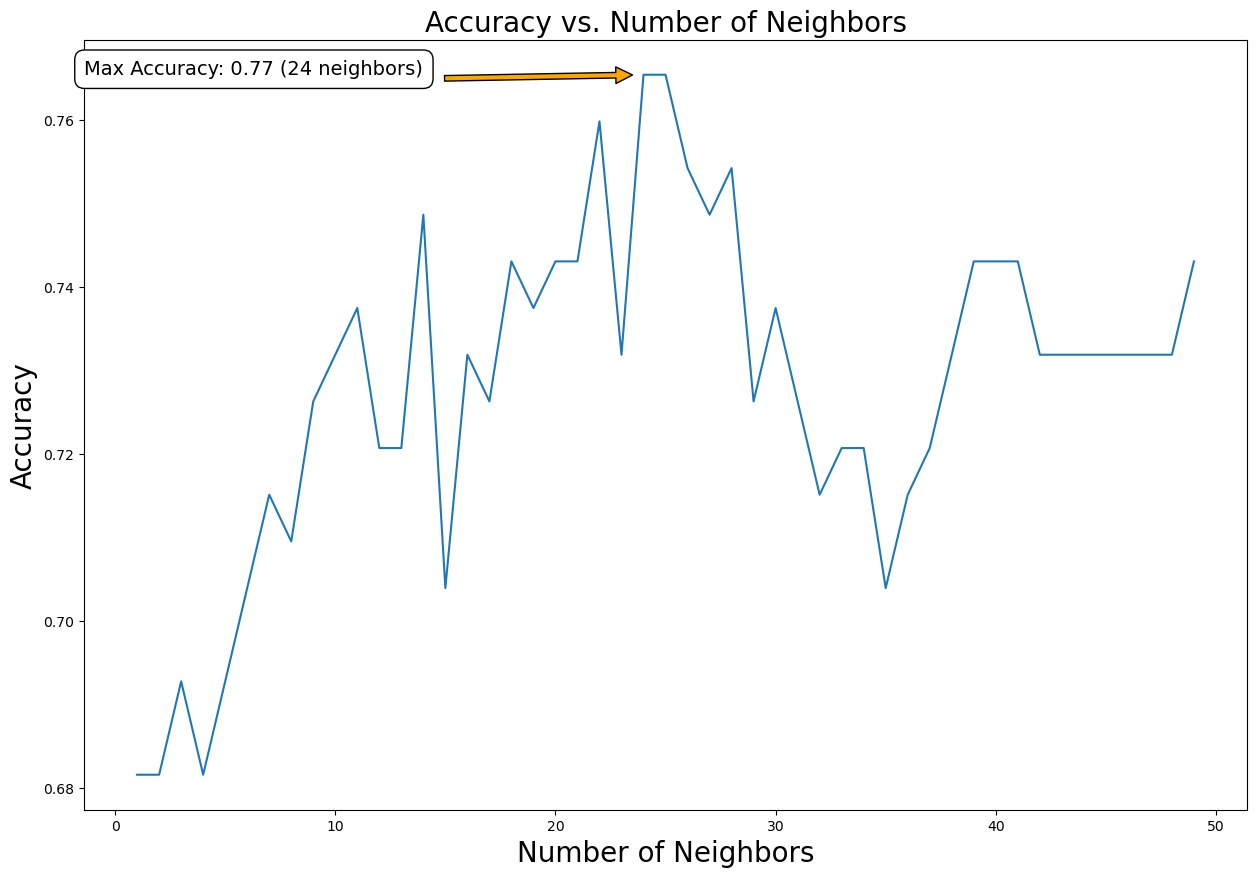

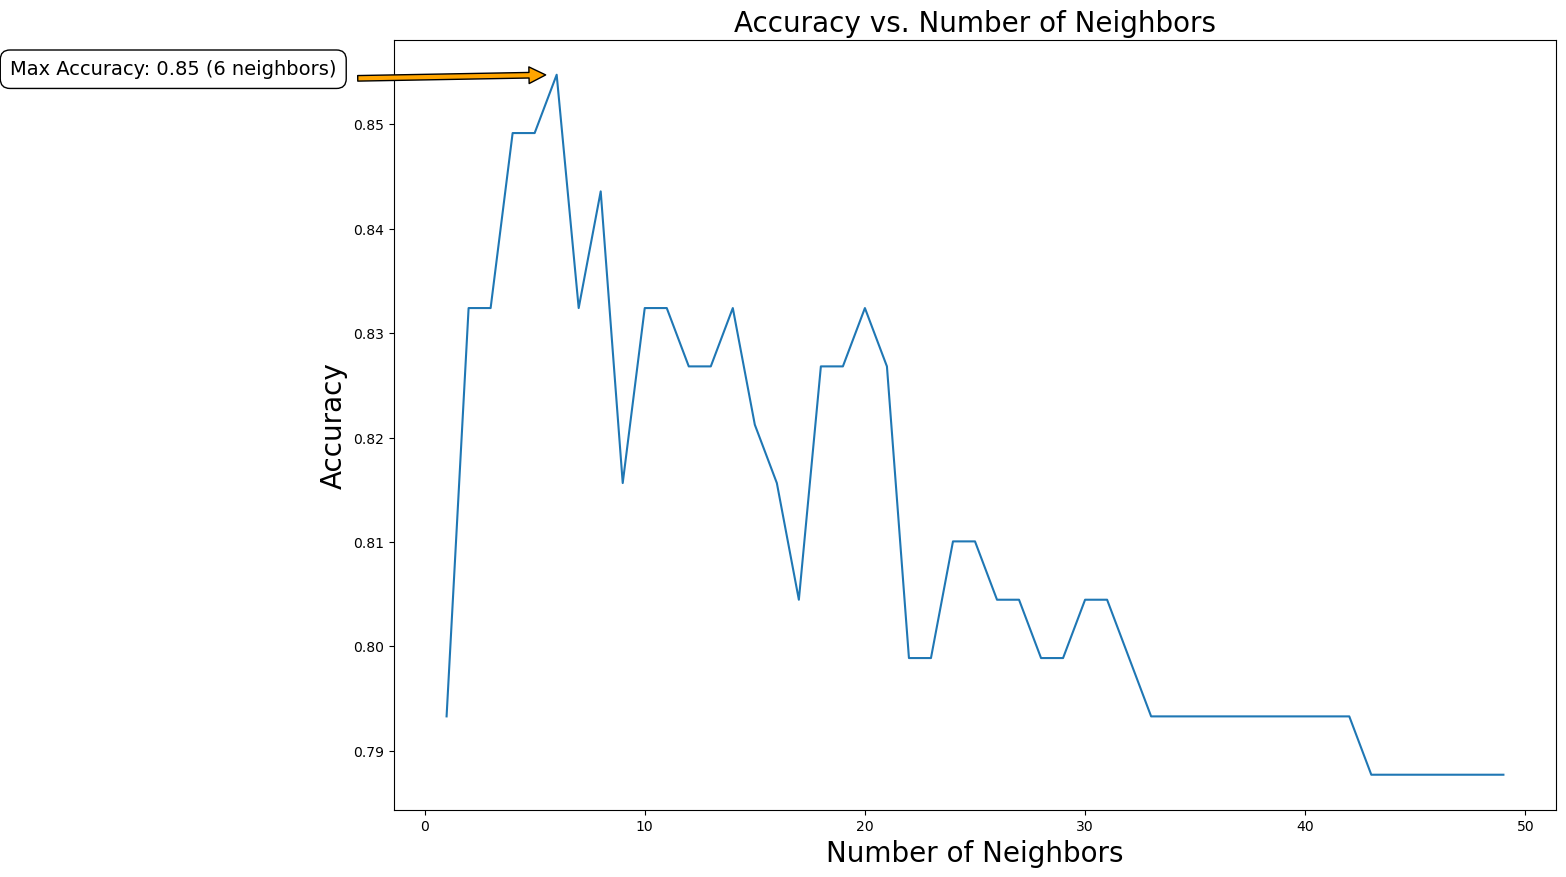

In [ ]:
# Example usage:
numerical_features = ['Fare', 'Age']
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

# Assuming x_train, y_train, x_test, and y_test are already defined
results_df = compare_feature_engineering_KNN(x_train, y_train, x_test, y_test, param_grid, numerical_features)
print(results_df)

[Go to the beginning of the assignment](#table-of-contents)

## Part 3 - Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 2)

# Naive Bayes training:

In [ ]:
def train_best_model():
    max_accuracy, best_technique, best_X_train, best_X_test,_ = get_best_feature_engineering_techniques(x_train, x_test, y_train, y_test) # Receiving the best results from the function

    # Train final model with the best feature engineering technique
    final_model = train_naive_bayes(best_X_train, y_train) 
    final_accuracy,_ = test_naive_bayes(final_model, best_X_test, y_test)

    return final_model, max_accuracy, best_technique, final_accuracy # Returning the model, max accuracy, best technique and final accuracy from test

In [ ]:
final_model, max_accuracy, best_technique, final_accuracy = train_best_model() # Training the model
print(f'Max Accuracy: {max_accuracy}')
print(f'Best Feature Engineering Technique: {best_technique}')
print(f'Final Model Accuracy: {final_accuracy}')

## Part 4 - Apply on test and show model performance estimation

## KNN algorithm testing:

In [ ]:
x_train_scaled, x_test_scaled = scaling(x_train,x_test)
accuracy, class_report_knn = KNN_Test(x_train_scaled, y_train, x_test_scaled, y_test,6)
print('Accuracy: ', accuracy)
print('-------------------------------------------------')
print('')
print('-------------------------------------------------')
print('Classification Report:\n', class_report_knn)

[Go to the beginning of the assignment](#table-of-contents)

## Naive Bayes algorithm testing:

In [ ]:
def train_best_model():
    max_accuracy, best_technique, best_X_train, best_X_test,_ = get_best_feature_engineering_techniques(x_train, x_test, y_train, y_test)

    # Train final model with the best feature engineering technique
    final_model = train_naive_bayes(best_X_train, y_train)
    final_accuracy, final_report = test_naive_bayes(final_model, best_X_test, y_test)

    return final_model, max_accuracy, best_technique, final_accuracy, final_report

def evaluate_model(model, X_test, y_test):
    accuracy, report = test_naive_bayes(model, X_test, y_test)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    return accuracy, report

In [ ]:
final_model, max_accuracy, best_technique, final_accuracy, final_report = train_best_model()
print(f'Max Accuracy: {max_accuracy}')
print(f'Best Feature Engineering Technique: {best_technique}')
print(f'Final Model Accuracy: {final_accuracy}')
print("Final Model Classification Report:")
print(final_report)

[Go to the beginning of the assignment](#table-of-contents)

In [42]:
y_train.shape

(712,)